In [8]:
import sys

project_dir = '/Users/alex/ml_class/project/'

sys.path.append(project_dir)

In [ ]:
from core.rolling_analysis import RollingAnalyzer
from core.utils import get_dfs, get_good_dfs, \
get_close_prices, fix_gaps_in_data, calc_returns, \
calc_log_prices, get_pairs
from sklearn.preprocessing import FunctionTransformer

import warnings
import numpy
import pandas as pd



warnings.simplefilter(action='ignore', category=FutureWarning)
m = 100
start_date = '2019-01-01'
end_date = '2019-03-01'

print("getting data")
dfs = get_dfs(project_dir + "data")
print("filtering to good ones")
good_dfs = get_good_dfs(dfs, 30000)
print("getting close prices")
closes = get_close_prices(good_dfs)
print("filling gaps")
closes = fix_gaps_in_data(closes)
print("filtering to USDT")
pairs = get_pairs(good_dfs)
closes_usdt = closes[pairs['USD']]

print("calculating log prices")
log_df = calc_log_prices(closes_usdt)
filtered_df = log_df[start_date:end_date]

print("calculating returns")
returns = calc_returns(closes_usdt)
print("-------------------")
print("Now rolling analysis")
rolling_analyzer = RollingAnalyzer(filtered_df, m)
print("Make the dfs")
rolling_analyzer.make_dfs()
rolling_analyzer.make_pairs()
print("Running all the regressions")
rolling_analyzer.run_all_regressions()
rolling_analyzer.calc_all_returns_stats()

print("Calculating dickey fullers")
rolling_analyzer.run_regressions('ETHUSDT', 'BTCUSDT')
rolling_analyzer.calc_dickey_fuller('ETHUSDT', 'BTCUSDT')

getting data
filtering to good ones
getting close prices
filling gaps
filtering to USDT
calculating log prices
calculating returns
-------------------
Now rolling analysis
Make the dfs
Running all the regressions
('LTCUSDT', 'BNBUSDT')
('TRXUSDT', 'BNBUSDT')
('TRXUSDT', 'LTCUSDT')
('ETHUSDT', 'BNBUSDT')
('ETHUSDT', 'LTCUSDT')
('ETHUSDT', 'TRXUSDT')
('BTCUSDT', 'BNBUSDT')
('BTCUSDT', 'LTCUSDT')
('BTCUSDT', 'TRXUSDT')
('BTCUSDT', 'ETHUSDT')
('EOSUSDT', 'BNBUSDT')
('EOSUSDT', 'LTCUSDT')
('EOSUSDT', 'TRXUSDT')
('EOSUSDT', 'ETHUSDT')
('EOSUSDT', 'BTCUSDT')
('ADAUSDT', 'BNBUSDT')
('ADAUSDT', 'LTCUSDT')
('ADAUSDT', 'TRXUSDT')
('ADAUSDT', 'ETHUSDT')
('ADAUSDT', 'BTCUSDT')
('ADAUSDT', 'EOSUSDT')
('XRPUSDT', 'BNBUSDT')
('XRPUSDT', 'LTCUSDT')
('XRPUSDT', 'TRXUSDT')
('XRPUSDT', 'ETHUSDT')
('XRPUSDT', 'BTCUSDT')
('XRPUSDT', 'EOSUSDT')
('XRPUSDT', 'ADAUSDT')
Calculating dickey fullers


['/Users/alex/ml_class/project/notebooks',
 '/anaconda3/lib/python37.zip',
 '/anaconda3/lib/python3.7',
 '/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/Users/alex/ml_class/project_venv/lib/python3.7/site-packages',
 '/Users/alex/ml_class/project_venv/lib/python3.7/site-packages/IPython/extensions',
 '/Users/alex/.ipython']

In [1320]:
import numpy as np
import matplotlib.pyplot as plt

def rename_columns(df, tag):
    new_column_names = [col + '_' + tag for col in df.columns]
    df.columns = new_column_names
    return df

mean_returns_df = rename_columns(rolling_analyzer.export_returns_stats_df(stat='mean_return'), 'mean')
volatility_df = rename_columns(rolling_analyzer.export_returns_stats_df(stat='volatility'), 'vol')
dickey_fuller_df = rename_columns(rolling_analyzer.export_dickey_fuller_df(), 'pval')
betas_df = rename_columns(rolling_analyzer.export_betas_df(), 'betas')

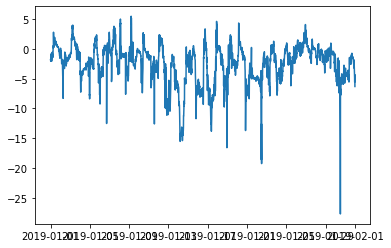

In [1321]:
def zero_to_one(x):
    return np.exp(x)/(1+np.exp(x))

def to_infinity(x):
    np.log(x/(1-x))


inf_dickey_fuller = np.log(series/(1-series))
plt.plot(inf_dickey_fuller['2019-01-01':'2019-01-31'])

In [1322]:
target_lags = {}
for i in range(0, m):
    code = 'y' + str(i)
    lag = inf_dickey_fuller.shift(-i)
    target_lags[code] = lag

y = pd.DataFrame(target_lags)

features_df = pd.concat([inf_dickey_fuller, mean_returns_df, volatility_df, betas_df], axis=1).dropna()
feature_lags = []
for i in range(0, m):
    lag_df = features_df.shift(i)
    lag_df.columns = [c + '_lag' + str(i) for c in list(features_df.columns)]
    feature_lags.append(lag_df)

all_lags = pd.concat(feature_lags, axis=1)
full_df = pd.concat([all_lags, y], axis=1).dropna()
full_df = full_df.replace([np.inf, -np.inf], 0)

In [1323]:
def make_train_test(df, ratio = 0.2, target=['y']):
    split_point = int((1 - ratio) * df.shape[0])
    y = df[target]
    x = df.drop(target, axis=1)
    y_train = y[0:split_point]
    x_train = x[0:split_point]
    y_test = y[(split_point + 1):]
    x_test = x[(split_point + 1):]
    out = {'train': {'x': x_train, 'y': y_train},
           'test': {'x': x_test, 'y': y_test}
          }
    return out
    
full_set = make_train_test(full_df, target=list(y.keys()))

/Users/alex/ml_class/project_venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/alex/ml_class/project_venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


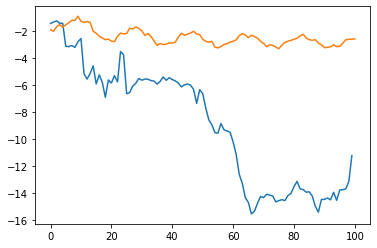

In [946]:
from statsmodels.tsa.arima_model import ARIMA

p_vals = full_set['train']['x']['BTCUSDT_ETHUSDT']
start = 200
in_sample_size = 1000
out_of_sample_size = 100
train = p_vals[start:(start+in_sample_size)]
test = p_vals[(start+in_sample_size+1):(start+in_sample_size+1+out_of_sample_size)]

model = ARIMA(
    train,
    order=(15, 1, 14),
    freq='15T'
)
model_fit = model.fit()
predictions = model.predict(
    params=model_fit.params,
    start=test.index[0],
    end=test.index[len(test)-1]
)
plt.plot(np.array(test))
plt.plot(test[0]+np.cumsum(predictions))

# Dimensionality Reduction

In [1351]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.9)),
    ('tsne', TSNE(n_components=2, random_state=42))
])

pca_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

x_pca_reduced = pd.DataFrame(pca_pipeline.fit_transform(full_set['train']['x']))
y_pca_reduced = pd.DataFrame(pca_pipeline.fit_transform(full_set['train']['y']))

In [1352]:
x_pca_reduced.index = full_set['train']['x'].index
y_pca_reduced.index = full_set['train']['y'].index

In [ ]:
x_pca_reduced.shape, y_pca_reduced.shape

In [1354]:
def rebuild_df(pca_df):
    rebuilt_df = pd.DataFrame(pca_pipeline.inverse_transform(pca_df))
    rebuilt_df.index = pca_df.index
    rebuilt_df.columns = ['y' + str(i) for i in range(rebuilt_df.shape[1])]
    return rebuilt_df

rebuilt_df = rebuild_df(y_pca_reduced)

In [1358]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

scaler = StandardScaler()

x_scaled = pd.DataFrame(scaler.fit_transform(x_pca_reduced))
x_scaled.index = x_pca_reduced.index
# y_scaled = scaler.fit_transform(y_pca_reduced)

model = SVR(kernel="poly", C=10)
multioutput_model = MultiOutputRegressor(model)
multioutput_model.fit(x_scaled, y_pca_reduced)

MultiOutputRegressor(estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='auto_deprecated',
                                   kernel='poly', max_iter=-1, shrinking=True,
                                   tol=0.001, verbose=False),
                     n_jobs=None)

In [1360]:
predicted = pd.DataFrame(
    multioutput_model.predict(x_scaled),
    index=full_set['train']['x'].index
)

In [1361]:
def rolled_mse(true_values, predicted, transform = True):
    mse_list = []
    for i in range(true_values.shape[0]):
        temp_true = true_values.iloc[i, :]
        temp_pred = predicted.iloc[i, :]
        if transform:
            temp_true = zero_to_one(temp_true)
            temp_pred = zero_to_one(temp_pred)
        temp_mse = mean_squared_error(temp_true, temp_pred)
        mse_list.append(temp_mse)
    return mse_list

def overall_rolled_mse(true_values, predicted, transform=True):
    mse_list = rolled_mse(true_values, predicted, transform)
    return np.mean(mse_list)

full_predicted = rebuild_df(predicted)

mse_list = rolled_mse(
    full_set['train']['y'],
    full_predicted
)

np.sqrt(overall_rolled_mse(full_set['train']['y'], full_predicted))

0.10363265109789908

array([[-6.41756862e-01,  1.45560007e+00, -5.88544104e-01, ...,
         1.06927698e+00, -3.45237175e-01,  9.17264030e-01],
       [-6.40735964e-01,  1.45886096e+00, -5.89652396e-01, ...,
         1.06695070e+00, -3.01386840e-01,  8.89431631e-01],
       [-6.40284750e-01,  1.46269022e+00, -5.89893812e-01, ...,
         1.06211342e+00, -2.60565646e-01,  8.59934042e-01],
       ...,
       [-5.92733938e-01, -5.50063103e-02, -2.76518452e-01, ...,
         2.63591990e+00, -8.13426855e-01,  3.04114287e-01],
       [-5.88253777e-01, -2.86843076e-02, -2.67435308e-01, ...,
         2.62173827e+00, -8.87869703e-01,  1.94131634e-01],
       [-5.84184671e-01, -2.04008211e-03, -2.58131298e-01, ...,
         2.58223401e+00, -9.61022845e-01,  8.37978866e-02]])

In [1362]:
def time_series_cross_val_split(x, y, predict_n=100):
    n = x.shape[0]
    split = n - predict_n
    in_sample_x = x.iloc[:(split - 1), :]
    in_sample_y = y.iloc[:(split - 1)]
    out_of_sample_x = x.iloc[split:, :]
    out_of_sample_y = y.iloc[split:, :]
    out = {
        'in': {'x': in_sample_x, 'y': in_sample_y},
        'out': {'x': out_of_sample_x, 'y': out_of_sample_y}
    }
    return out
    
split = time_series_cross_val_split(pd.DataFrame(x_scaled), y_pca_reduced)

In [1363]:
multiouput_model.fit(split['in']['x'], split['in']['y'])

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                   epsilon=0.1, gamma='auto_deprecated',
                                   kernel='rbf', max_iter=-1, shrinking=True,
                                   tol=0.001, verbose=False),
                     n_jobs=None)

In [1391]:
predictions = pd.DataFrame(
    multioutput_model.predict(split['out']['x']),
    index=split['out']['x'].index
)
true_values = split['out']['y']
true_values_df = rebuild_df(true_values)
prediction_df = rebuild_df(predictions)

np.sqrt(overall_rolled_mse(true_values_df, prediction_df))

0.053572911723370725

In [1]:
plt.plot(true_values_df.iloc[100-1, :])
plt.plot(prediction_df.iloc[100-1, :])

NameError: name 'plt' is not defined

In [1300]:
y_hat_transform = rebuild_df(
    y_hat,
    full_set['train']['y'].columns,
    full_set['train']['y'].index
)

array([[-9.12055501e+00,  2.17266942e+00,  7.38241390e-01,
         2.42502162e+00,  7.58473779e-02, -2.25976643e+00,
         8.94985179e-01, -1.13274527e+00, -2.44627462e+00,
         4.99689936e-02],
       [-8.80428947e+00,  2.28779687e+00,  8.12175444e-01,
         2.61216801e+00, -3.25220636e-01, -2.04968225e+00,
         8.76157542e-01, -1.03918892e+00, -2.60606906e+00,
        -7.06176063e-03],
       [-8.45743369e+00,  2.37394127e+00,  8.68450592e-01,
         2.76195938e+00, -7.01548958e-01, -1.82372050e+00,
         8.50695230e-01, -9.32462488e-01, -2.74168232e+00,
        -6.48297157e-02],
       [-8.08126923e+00,  2.42699509e+00,  9.09096421e-01,
         2.87184727e+00, -1.04265246e+00, -1.58461571e+00,
         8.20486770e-01, -8.14069874e-01, -2.84604739e+00,
        -1.23859246e-01],
       [-7.67118253e+00,  2.44621954e+00,  9.34623872e-01,
         2.94014638e+00, -1.34786512e+00, -1.33230529e+00,
         7.84800284e-01, -6.85291327e-01, -2.91751809e+00,
        -1.

In [435]:
def time_series_cross_val_predict(model, x, y, folds=10):
    if folds < 5:
        print("Must have 5 or more folds")
        return
    else:
        x_folds = time_series_kfolds(x, folds=folds)
        y_folds = time_series_kfolds(y, folds=folds)
        predictions = []
        true_values = []
        for i in range(3, folds):
            x_train = pd.concat([x_folds[i-3], x_folds[i-2], x_folds[i-1]], axis=0)
            y_train = pd.concat([y_folds[i-3], y_folds[i-2], y_folds[i-1]], axis=0)
            x_test = x_folds[i]
            true_values.append(y_folds[i])
            model.fit(x_train, y_train)
            temp_predictions = model.predict(x_test)
            predictions.append(temp_predictions)
        out = {'true_values': true_values, 'predictions': predictions}
        return out

In [345]:
pipeline = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('svr', SVR(C=0.5, kernel='poly'))
])

cross_val_predictions = time_series_cross_val_predict(
    pipeline,
    full_set['train']['x'],
    full_set['train']['y'], folds=20
)

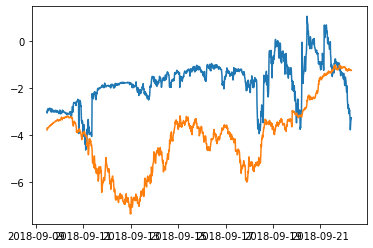

In [409]:
fold = 4

plt.plot(cross_val_predictions['true_values'][fold])
prediction_s = pd.Series(
    cross_val_predictions['predictions'][fold],
    index=cross_val_predictions['true_values'][fold].index
)
plt.plot(prediction_s)

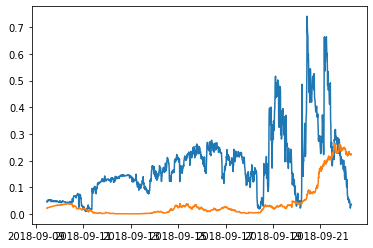

In [355]:
plt.plot(zero_to_one(cross_val_predictions['true_values'][fold]))
plt.plot(zero_to_one(prediction_s))

In [359]:
from sklearn.metrics import mean_squared_error

zero_to_one(np.sqrt(mean_squared_error(cross_val_predictions['true_values'][fold], prediction_s)))

0.9423785494083549

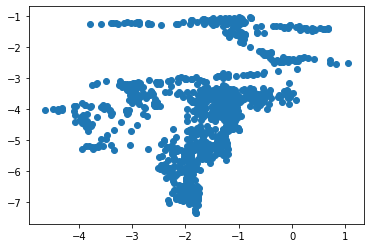